## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('./ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [5]:
df[df['converted'] == 1].shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query("landing_page =='new_page' and group != 'treatment' or landing_page != 'new_page' and group == 'treatment' ").shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.query("landing_page =='new_page' and group == 'treatment' or landing_page == 'old_page' and group == 'control'")

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].set_index(['user_id']).index

Int64Index([773192], dtype='int64', name='user_id')

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2=df2.drop_duplicates(subset='user_id', keep="last")

In [14]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2[df2['converted'] == 1].shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query("converted == 1 and group =='control'").shape[0]/df2[df2['group']=='control'].shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query("converted == 1 and group =='treatment'").shape[0]/df2[df2['group']=='treatment'].shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query("landing_page=='new_page'").shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The probability of converting for an individual who received the control page is 0.1204and for the one who received the treatment page is 0.1188.

The probability of coverting for people receiving the control page and the probability of converting for those receiving the treatment page seems to be almost equal so we conclude that there is no evidence that the new page push people to make more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypotheses:pnew-pold <=0



Alternative hyptheses:pnew-pold>0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
 pnew=df2[df2['converted'] == 1].shape[0]/df2.shape[0]
pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
pold=df2[df2['converted'] == 1].shape[0]/df2.shape[0]
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2[df2['group'] == "treatment"].user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df2['group'] == "control"].user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted=np.random.choice(2,size=n_new,p=[1-pnew,pnew])
new_page_converted

array([1, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted=np.random.choice(2,size=n_old,p=[1-pold,pold])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean()-old_page_converted.mean()

8.0795783602885529e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs=[]
for i in range(0,10000):
    new_page_converted=np.random.choice(2,size=n_new,p=[1-pnew,pnew])
    old_page_converted=np.random.choice(2,size=n_old,p=[1-pold,pold])
    pDiff=new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(pDiff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([    9.,    47.,   321.,  1208.,  2471.,  2927.,  1971.,   844.,
          179.,    23.]),
 array([-0.00486813, -0.00395412, -0.00304011, -0.0021261 , -0.00121208,
        -0.00029807,  0.00061594,  0.00152995,  0.00244396,  0.00335797,
         0.00427199]),
 <a list of 10 Patch objects>)

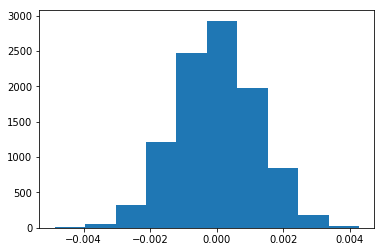

In [27]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs >  df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()).mean()

0.90539999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value computed above is the p-value which is equal to 0.903. As specified above, alpha is equal to 0.05 . In our experiment, the p-value is larger than alpha so we fail to ignore the null hypothesis. There is no difference between the old and new pages in conversion rates.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query("landing_page =='old_page' and converted ==1").shape[0]
convert_new = df2.query("landing_page =='new_page' and converted ==1").shape[0]
n_old = df2.query("landing_page =='old_page'").shape[0]
n_new = df2.query("landing_page =='new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
zstat, pval =sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new],alternative='smaller')
display(zstat, pval)

1.3109241984234394

0.90505831275902449

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The p-value is 0.905 which is larger than 0.05(alpha) so we fail to reject the null hypthesis and we conclude that the new page is not better than the old one regarding the conversion rate.
the z-score is 1.31 and the critical value for alpha =0.05 is 1.96 since the z score is smaller than the critical value  we fail to reject the null hypthesis

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('control', axis=1, inplace=True)

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-09 12:11 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

the p value associated with ab_page is 0.1899 .In part II ,the null hypothesis was that the new page is equal or less than the old page in the converting rate but here in part III the null hypothesis is that the new page is equal to the old's page in the converting rate and the alternative hypthesis is that the new page differs from the old one in the converting rate.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It's a good idea to consider other factors to add into my regression model to investgate if there is another factor that impacts the converting rate of the pages.

But adding factors to the regression model can make us have some problems like Multicollinearity


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [34]:
countries = pd.read_csv('countries.csv')
newdf = df2.set_index('user_id').join(countries.set_index('user_id'))
display(newdf.country.value_counts())
newdf[['US', 'UK','CA']] =  pd.get_dummies(newdf['country'])
newdf.drop(['CA'], axis=1,inplace=True)
newdf.head(2)
logit = sm.Logit(newdf['converted'], newdf[['intercept', 'US','UK']])
results = logit.fit()
results.summary2()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-09 12:11 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
US           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

The p-values for the countries are all bigger than 0.05 (alpha) so we conclude that the countries are statisticlly nonsignificant in the converting rate .

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [35]:
newdf['us_page'] = newdf['US'] * newdf['ab_page']
newdf['uk_page'] = newdf['UK'] * newdf['ab_page']
logit = sm.Logit(newdf['converted'], newdf[['intercept', 'us_page','uk_page']])
results = logit.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-09 12:11 AIC:              212779.0384
No. Observations:   290584           BIC:              212810.7773
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
us_page      -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
uk_page       0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

The p value of the us page is smaller than 0.05(alpha) so we conclude that the interaction between pages and a specific country is statisticlly significant in the converting rate .So we understand that the conversion rate of the page depends on the country. 

### Final Conclusion

The project 's goal is to decide if we should implement the new page or keep the old page.

At first we decided that the null hypthesis would be that the new page is less effective or equally effective as the old one .
After analysis and making the study ,we found the p-value of 0.905,and we found the z value less than the critical value of 95% confidence nterval  so we can not reject the null hypothesis. 


Then,we used a logistic regression model to if there is a significant difference in conversion based on which page a customer receives,the p value was different from the one calculated previously because In part II ,the null hypothesis was that the new page is equal or less than the old page in the converting rate but here in part III the null hypothesis is that the new page is equal to the old's page in the converting rate and the alternative hypthesis is that the new page differs from the old one in the converting rate.However in part III, the p value indicated that we also fail to reect the null hypothesis.

We then saw the effect of the country in which a user lives ,we added it into the regression model, .The p values of all countries showed that the user's country did not significantly affect their converting rate.

AT last,we added into the regression model the interaction between between page and country to see if there significant effects on conversion and we found that the page in the country of US is statisticlly significant in the converting rate .

So we conclude that It's best to implement the new page in specific countries like US as it increases the converting rate there but for other countries there is no evidence that the new page makes the converting rates higher .

In [36]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0